In [54]:
from datetime import timedelta, date, datetime, timezone

import pandas as pd
from matplotlib import pyplot as plt

# Section: flux, label, is_live
sections: list[tuple[pd.Series, str, bool]] = []

In [70]:
"""
Load interesting sections from the archive data.
"""
from importer.archive import _from_timeseries, _select_best_source
from sunpy.timeseries import TimeSeries
from sunpy.net import Fido
from sunpy.net import attrs
from sunpy import config
import os
import glob

# Sample dates with various edge cases
ARCHIVE_DATES = (
    '1980-05-28', '1980-06-15', '1980-06-27', '1980-07-13',
    '1980-09-25', '1980-09-28', '1984-02-06', '1984-09-20',
    '1986-09-09', '1985-05-02', '1985-07-01', '1985-08-31',
    '1985-12-02', '1986-02-26', '1986-04-07', '1986-07-28',
    '1987-09-03', '1988-03-22', '1991-04-30', '1995-10-04',
    '1995-10-06', '1996-07-07', '2002-12-19', '2002-12-20',
    '2008-09-14', '2009-09-22', '2017-09-06'
)
ARCHIVE_SECTION_SIZE = timedelta(days=3)


def _search_cached(start: date, end: date) -> tuple[list[str], bool]:
    cache_dir = config.get('downloads', 'download_dir')
    dates = pd.date_range(start, end, freq='D')
    cached_files = []
    for sub_date in dates:
        for pattern in (
                f'go??{sub_date.strftime("%y%m%d")}.fits',
                f'sci_*xrs*-l2-*_g*_d{sub_date.strftime("%Y%m%d")}_v*.nc'
        ):
            candidates = glob.glob(os.path.join(cache_dir, pattern))
            if len(candidates) == 0:
                continue
            cached_files.append(candidates[0])
            break
    return cached_files, len(cached_files) == len(dates)


def _search_and_fetch(start: date, end: date):
    results = Fido.search(
        attrs.Time(start, end),
        attrs.Instrument("XRS")
    )
    results = _select_best_source(results)
    return Fido.fetch(results)


for date_str in ARCHIVE_DATES:
    start_date = date.fromisoformat(date_str)
    end_date = start_date + ARCHIVE_SECTION_SIZE
    print(f'Loading {start_date} to {end_date}')

    files, is_cache_complete = _search_cached(start_date, end_date)
    if is_cache_complete:
        print('Loading from cache')
    else:
        try:
            files = _search_and_fetch(start_date, end_date)
        except Exception as e:
            print(f'Failed to search and download {date_str}: {e}')
    if len(files) == 0:
        print('Download failed or no data found.')
        continue

    series = TimeSeries(files, concatenate=True)
    sections.append((
        _from_timeseries(series),
        date_str,
        False
    ))

Loading 1980-05-28 to 1980-05-31
Loading from cache


KeyboardInterrupt: 

In [56]:
"""
Load all available live data.
Is a separate case because it is minute averaged.
"""
from importer.live import _select_live_url, _from_live_json
from aiohttp import ClientSession

live_start = datetime.now(timezone.utc) - timedelta(days=7)
async with ClientSession() as session:
    async with session.get(_select_live_url(live_start)) as response:
        live_flux = _from_live_json(await response.json())

sections.append((live_flux, 'live', True))

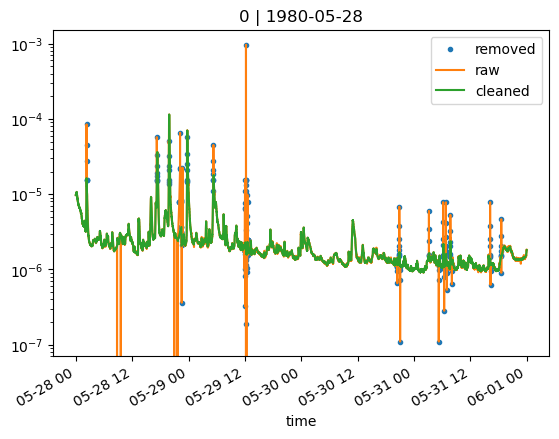

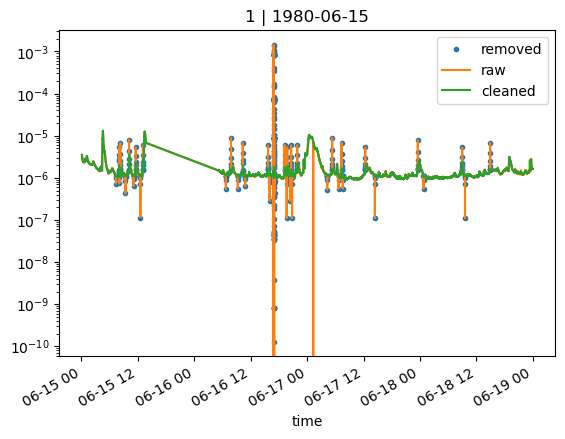

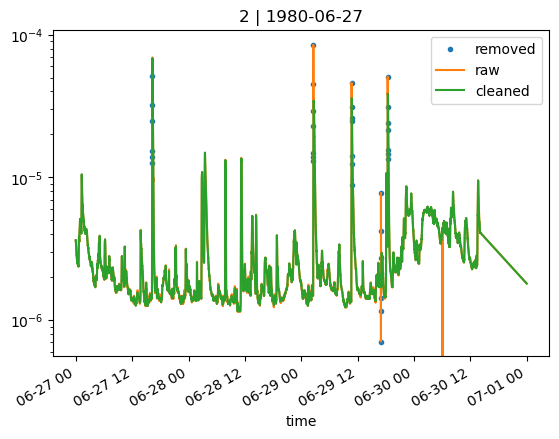

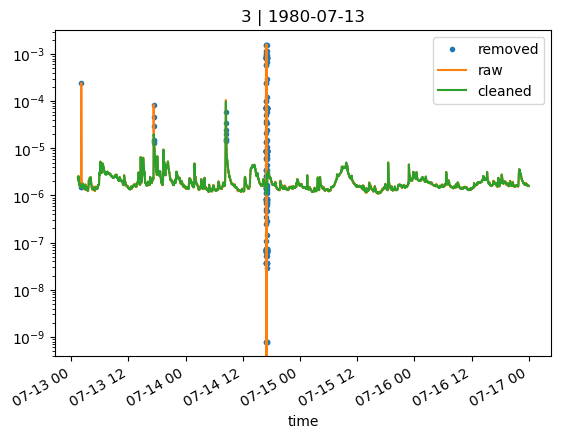

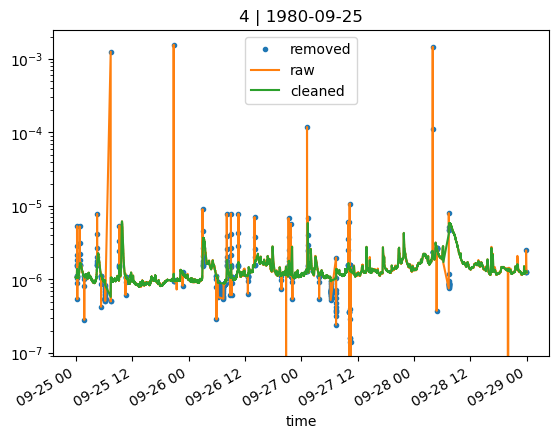

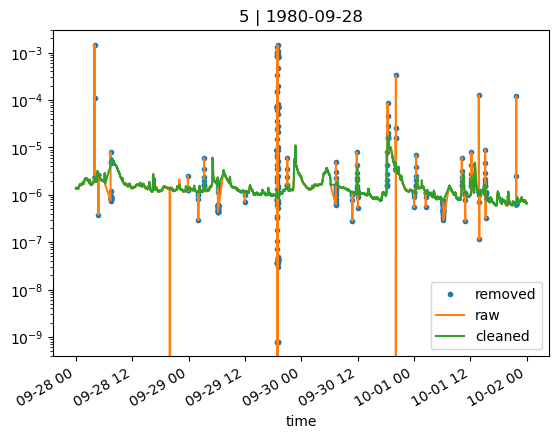

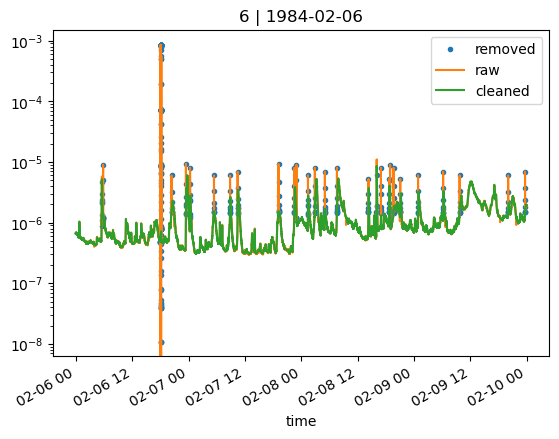

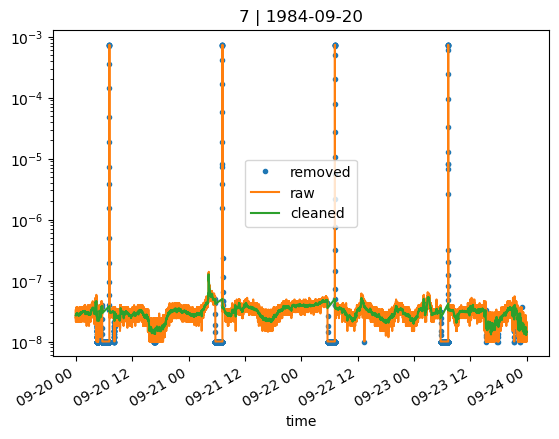

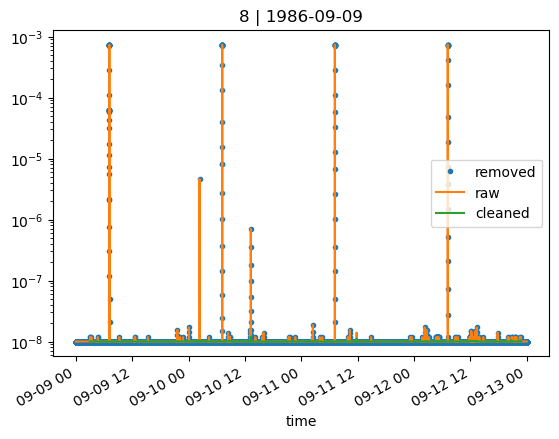

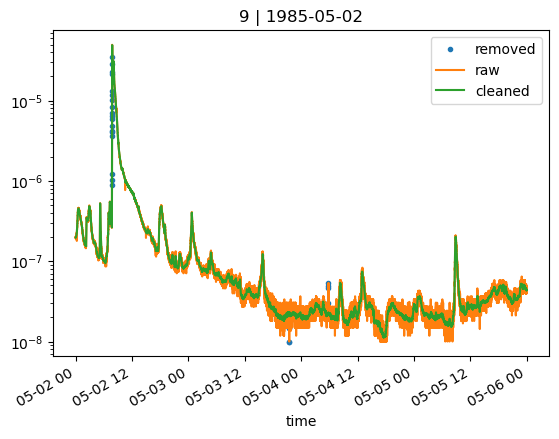

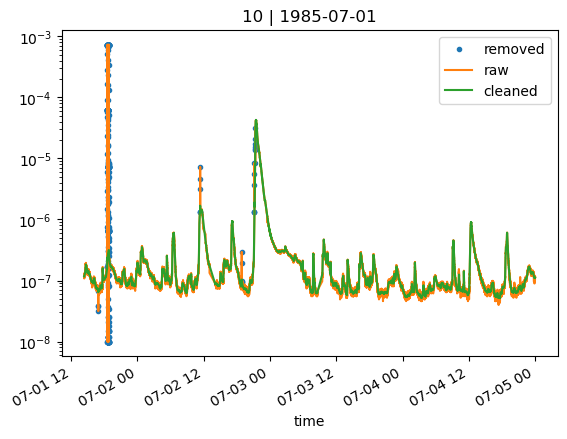

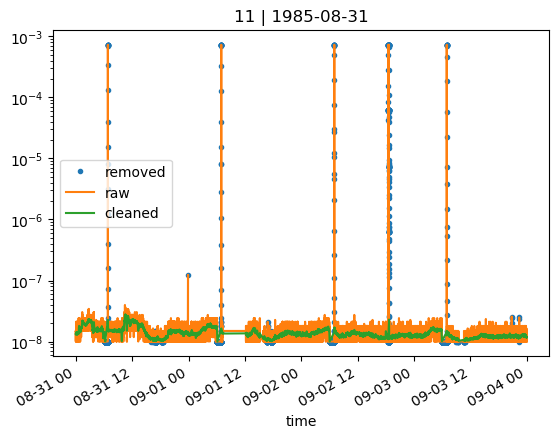

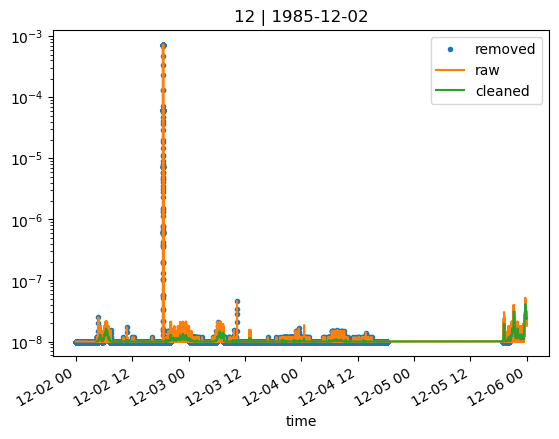

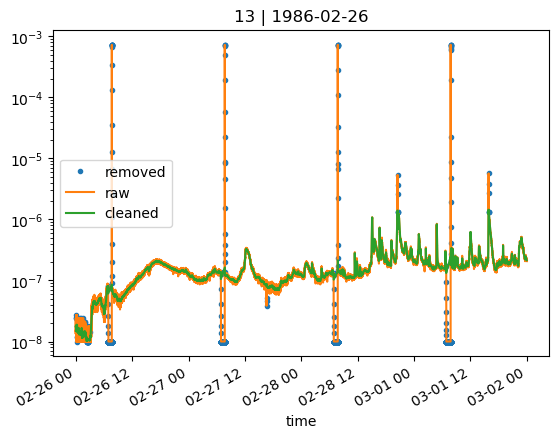

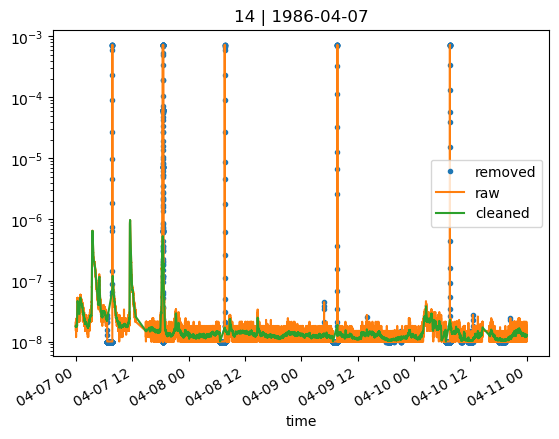

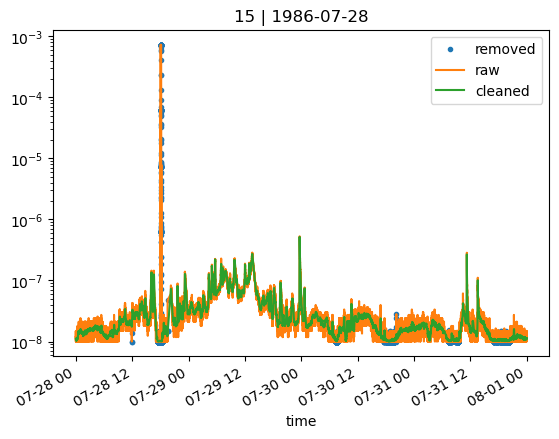

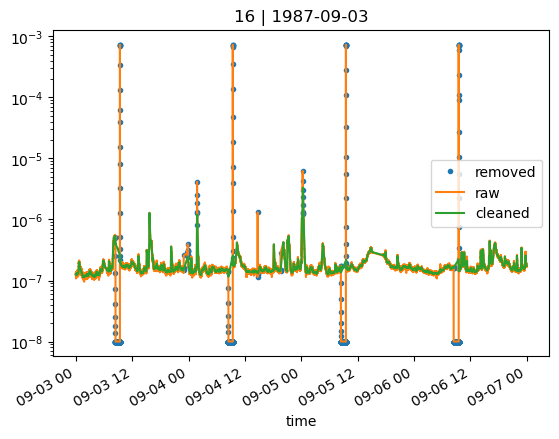

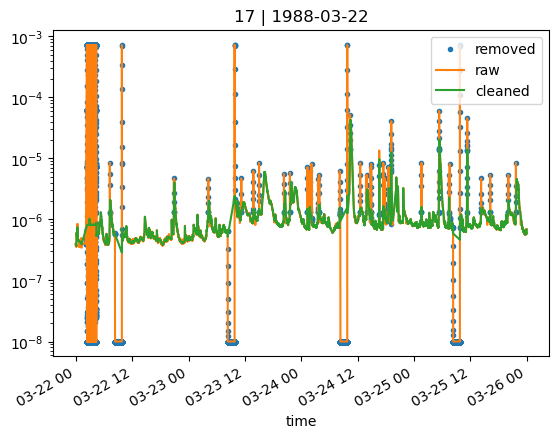

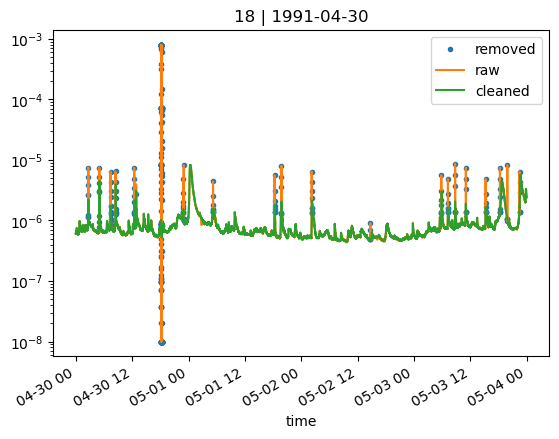

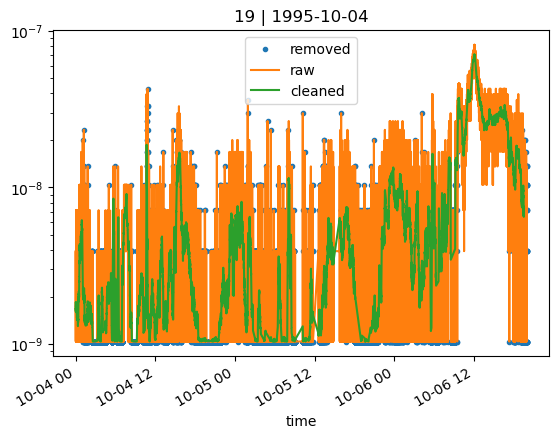

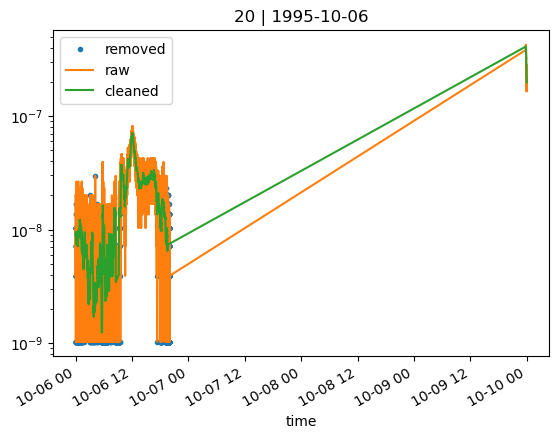

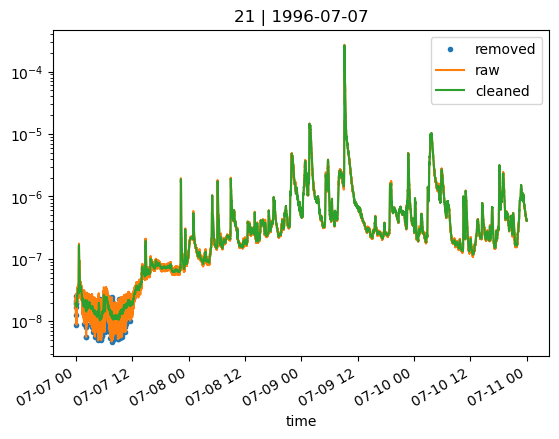

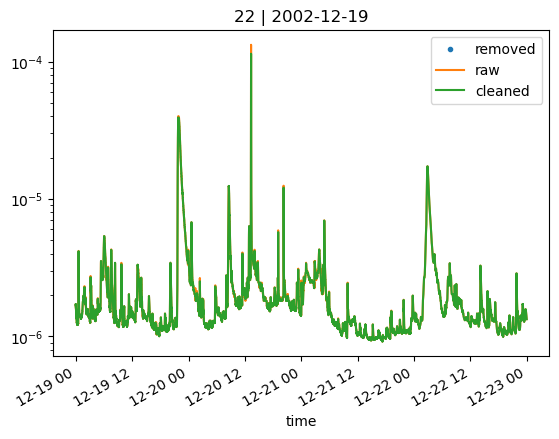

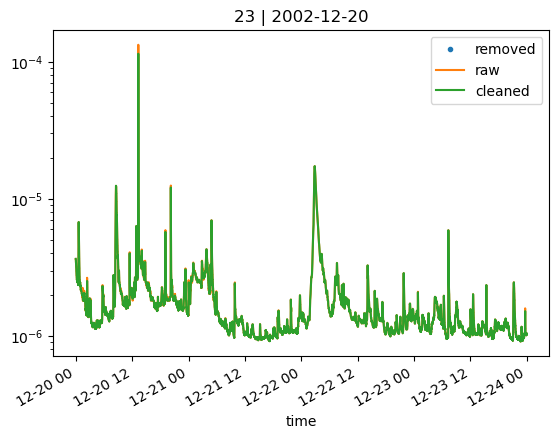

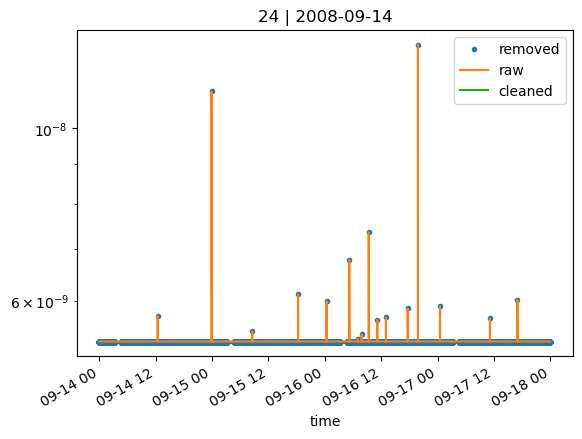

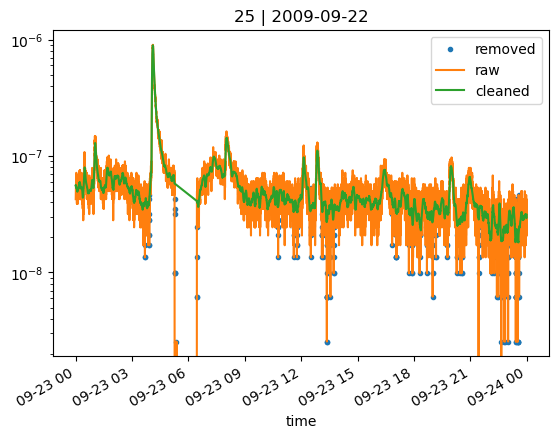

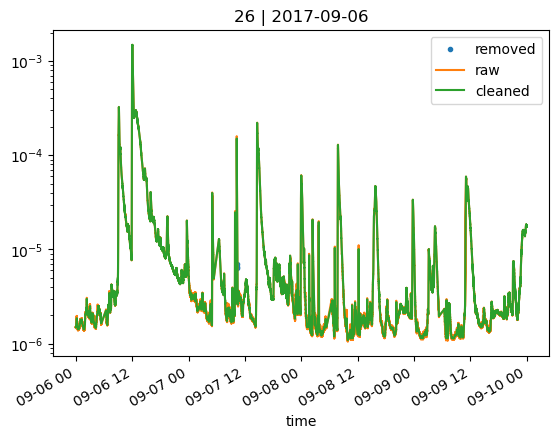

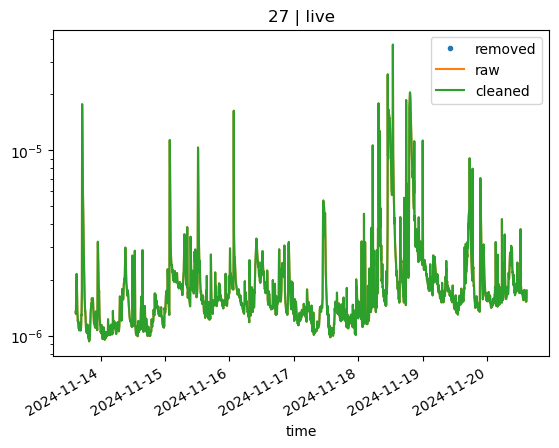

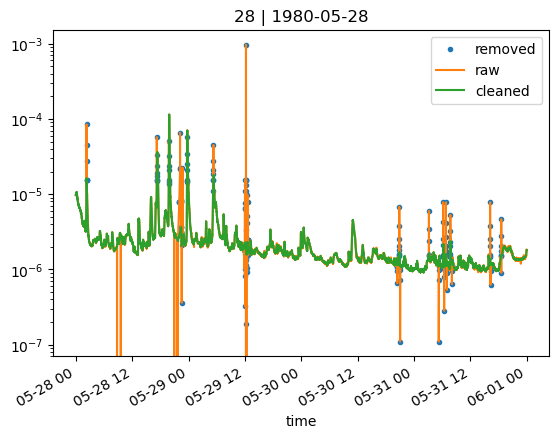

In [74]:
import importlib
import importer._clean as clean_module

# Reload clean module for easier development
importlib.reload(clean_module)
clean_flux = clean_module.clean_flux

for i, (raw, label, is_live) in enumerate(sections):
    cleaned = clean_flux(raw, is_live)
    ax = raw[~raw.index.isin(cleaned.index)].plot(
        title=f'{i} | {label}',
        logy=True,
        marker='.',
        linestyle='none',
        label='removed'
    )
    raw.rename('raw').plot(ax=ax)
    cleaned.rename('cleaned').plot(ax=ax)
    plt.legend()
    plt.show()